# Service 1

In [16]:
import pandas as pd

data = pd.read_csv('Service2.csv', parse_dates=['timestamp'])

# Preview Data
data.head()

,timestamp,cpu_allocated,memory_allocated,cpu_usage_pct,memory_usage_pct,latency_ms
0,2025-05-05 02:13:37.453505,1.0,2048.00,0.25,0.0,128.06
1,2025-05-05 02:14:37.453505,1.0,2047.82,0.25,0.0,120.40
2,2025-05-05 02:15:37.453505,1.0,2047.64,0.25,0.0,100.65
3,2025-05-05 02:16:37.453505,1.0,2047.46,0.25,0.0,122.88
4,2025-05-05 02:17:37.453505,1.0,2047.28,0.25,0.0,107.56


## Plot Latency vs CPU Usage

Text(0.5, 1.0, 'Latency vs CPU Usage')

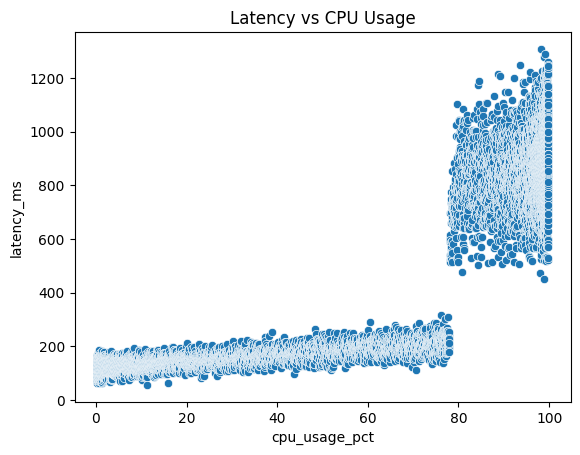

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.scatterplot(data, x="cpu_usage_pct", y = "latency_ms")
plt.title("Latency vs CPU Usage")

## Plot Latency vs Memory Usage

Text(0.5, 1.0, 'Latency vs Memory Usage')

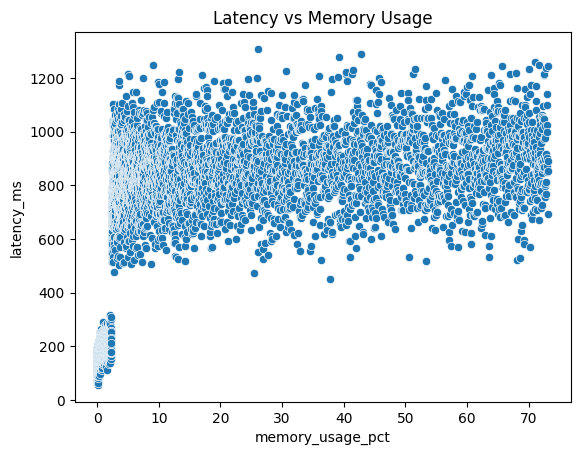

In [18]:
sns.scatterplot(data=data, x="memory_usage_pct", y = "latency_ms")
plt.title("Latency vs Memory Usage")

## Latency Over Time + CPU/Memory Overlay

Text(0.5, 1.0, 'Latency & CPU Usage Over Time')

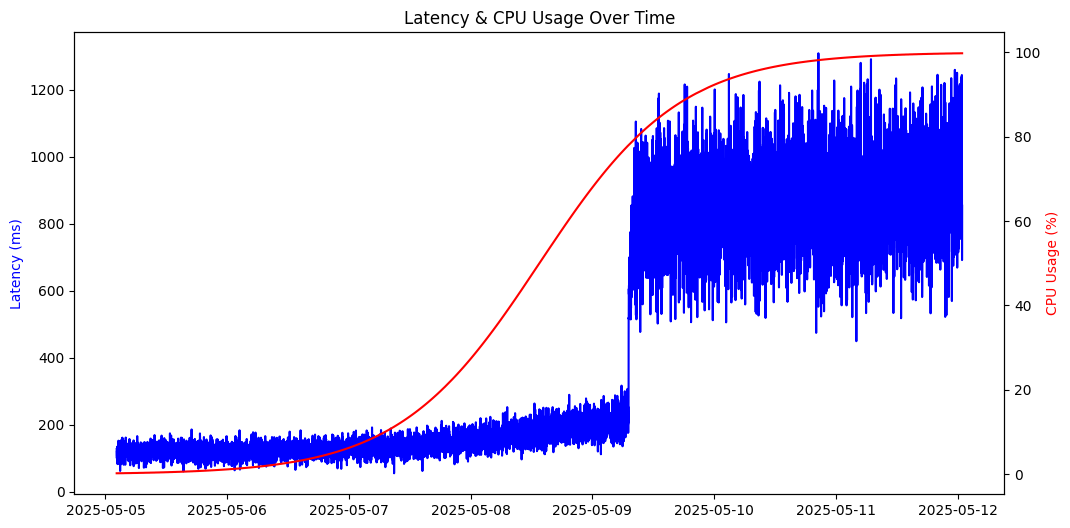

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Latency plot
ax1.plot(data['timestamp'], data["latency_ms"], label="latency", color = "blue")
ax1.set_ylabel('Latency (ms)', color = 'blue')

# Add CPU usage on secondary y-axis
ax2 = ax1.twinx()
ax2.plot(data["timestamp"], data['cpu_usage_pct'], label = 'CPU Usage', color = 'red')
ax2.set_ylabel('CPU Usage (%)', color = 'red')

plt.title('Latency & CPU Usage Over Time')

## Lag Analysis Before Spikes (Latency as Target)

Text(0.5, 1.0, 'Latency vs CPU Usage 5 intervals earlier')

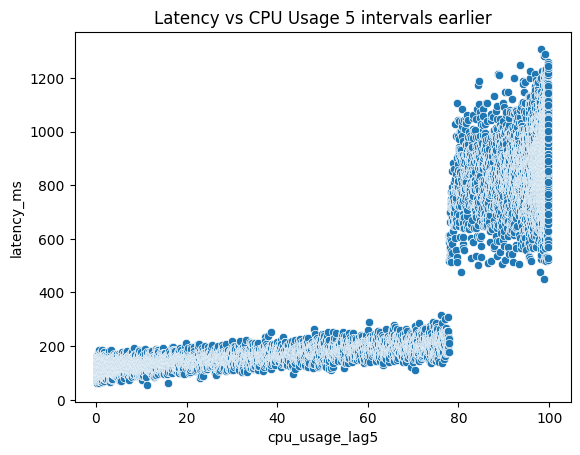

In [20]:
data['cpu_usage_lag5'] = data['cpu_usage_pct'].shift(5)
data['memory_usage_lag5'] = data['memory_usage_pct'].shift(5)

sns.scatterplot(data=data, x='cpu_usage_lag5', y='latency_ms')
plt.title("Latency vs CPU Usage 5 intervals earlier")


## Detect Spike Windows

In [21]:
import numpy as np

# Define a spike
data['latency_diff'] = data['latency_ms'].diff()
data['is_spike'] = data['latency_diff'] > data['latency_ms'].mean()

# Plot spike triggers
spike_windows = data[data['is_spike']]

# Plot CPU/Memory around spike times
for i, row in spike_windows.iterrows():
    print(f"Spike at {row['timestamp']} | CPU: {row['cpu_usage_pct']} | Mem: {row['memory_usage_pct']}")


Spike at 2025-05-09 11:55:37.453505 | CPU: 83.36 | Mem: 3.26
Spike at 2025-05-09 12:53:37.453505 | CPU: 84.3 | Mem: 3.49
Spike at 2025-05-09 12:59:37.453505 | CPU: 84.4 | Mem: 3.52
Spike at 2025-05-09 13:37:37.453505 | CPU: 84.99 | Mem: 3.67
Spike at 2025-05-09 14:53:37.453505 | CPU: 86.11 | Mem: 4.01
Spike at 2025-05-09 16:21:37.453505 | CPU: 87.33 | Mem: 4.44
Spike at 2025-05-09 18:06:37.453505 | CPU: 88.66 | Mem: 5.0
Spike at 2025-05-09 20:41:37.453505 | CPU: 90.4 | Mem: 5.97
Spike at 2025-05-10 00:54:37.453505 | CPU: 92.73 | Mem: 7.92
Spike at 2025-05-10 02:54:37.453505 | CPU: 93.64 | Mem: 9.03
Spike at 2025-05-10 04:13:37.453505 | CPU: 94.19 | Mem: 9.84
Spike at 2025-05-10 08:08:37.453505 | CPU: 95.55 | Mem: 12.64
Spike at 2025-05-10 08:13:37.453505 | CPU: 95.58 | Mem: 12.71
Spike at 2025-05-10 08:45:37.453505 | CPU: 95.74 | Mem: 13.14
Spike at 2025-05-10 08:49:37.453505 | CPU: 95.76 | Mem: 13.19
Spike at 2025-05-10 08:56:37.453505 | CPU: 95.79 | Mem: 13.29
Spike at 2025-05-10 14:

## Find Safe Allocation Bounds

In [22]:
high_latency = data[data['latency_ms'] > data['latency_ms'].mean()]

# CPU/memory levels during spikes
print("Typical CPU during spikes:", high_latency['cpu_usage_pct'].describe())
print("Typical Memory during spikes:", high_latency['memory_usage_pct'].describe())


Typical CPU during spikes: count    3945.000000
mean       94.806537
std         5.753009
min        78.020000
25%        92.060000
50%        97.430000
75%        99.200000
max        99.750000
Name: cpu_usage_pct, dtype: float64
Typical Memory during spikes: count    3945.000000
mean       27.248793
std        22.078048
min         2.340000
25%         7.240000
50%        20.320000
75%        45.430000
max        73.110000
Name: memory_usage_pct, dtype: float64


### Compare With The Normal Case

In [23]:
low_latency = data[data['latency_ms'] <= data['latency_ms'].mean()]
print("CPU safe range:", low_latency['cpu_usage_pct'].quantile([0.1, 0.9]))
print("Memory safe range:", low_latency['memory_usage_pct'].quantile([0.1, 0.9]))

CPU safe range: 0.1     0.510
0.9    63.158
Name: cpu_usage_pct, dtype: float64
Memory safe range: 0.1    0.00
0.9    1.14
Name: memory_usage_pct, dtype: float64
